In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [2]:
dataset_path = "Augmented Dataset"

categories = ["Black Spot", "Downy Mildew", "Fresh Leaf"]

IMG_SIZE = (256, 256)

X = [] 
y = []
image_sizes = [] 

def preprocess_image(img_path, target_size=(256, 256)):
    """Load an image, resize it, and normalize pixel values."""
    img = Image.open(img_path).convert("RGB")
    original_size = img.size
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array, original_size

In [3]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    class_index = categories.index(category)

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)

        img_array, original_size = preprocess_image(img_path, IMG_SIZE)

        X.append(img_array)
        y.append(class_index)
        image_sizes.append(original_size)


In [5]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)  

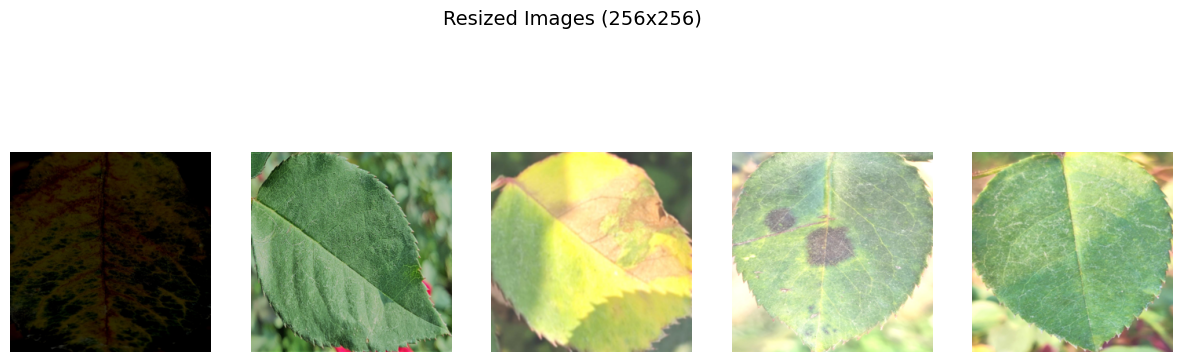

In [6]:
# demonstration of resized images from the dataset
num_samples = 5
indices = np.random.choice(len(X), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(indices):
    img = X[idx]  
    axes[i].imshow(img)
    axes[i].axis("off")

plt.suptitle("Resized Images (256x256)", fontsize=14)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [8]:
class SobelLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(SobelLayer, self).__init__(**kwargs)

    def call(self, inputs):
        sobel_x = tf.image.sobel_edges(inputs)[..., 0]  # Extract X gradient
        sobel_y = tf.image.sobel_edges(inputs)[..., 1]  # Extract Y gradient
        sobel_magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
        return sobel_magnitude

In [9]:
# Build CNN model
model = tf.keras.Sequential([
    SobelLayer(input_shape=(256, 256, 3)),  # Apply Sobel filter
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse because labels are integers
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/10
92/92 [==============================] - 180s 2s/step - loss: 1.0249 - accuracy: 0.5498 - val_loss: 0.6245 - val_accuracy: 0.7275
Epoch 2/10
92/92 [==============================] - 194s 2s/step - loss: 0.6334 - accuracy: 0.7110 - val_loss: 0.5048 - val_accuracy: 0.8011
Epoch 3/10
92/92 [==============================] - 199s 2s/step - loss: 0.4638 - accuracy: 0.7986 - val_loss: 0.4777 - val_accuracy: 0.8079
Epoch 4/10
92/92 [==============================] - 183s 2s/step - loss: 0.3107 - accuracy: 0.8763 - val_loss: 0.4504 - val_accuracy: 0.8365
Epoch 5/10
92/92 [==============================] - 170s 2s/step - loss: 0.1976 - accuracy: 0.9271 - val_loss: 0.3072 - val_accuracy: 0.8896
Epoch 6/10
92/92 [==============================] - 175s 2s/step - loss: 0.1248 - accuracy: 0.9516 - val_loss: 0.3121 - val_accuracy: 0.8924
Epoch 7/10
92/92 [==============================] - 164s 2s/step - loss: 0.1035 - accuracy: 0.9611 - val_loss: 0.2707 - val_accuracy: 0.8937
Epoch 8/10
92

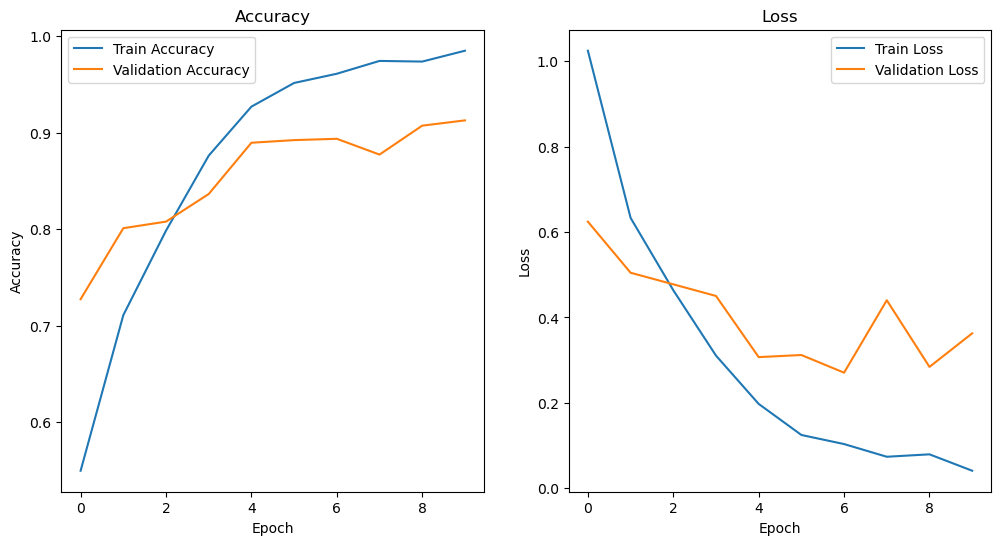

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

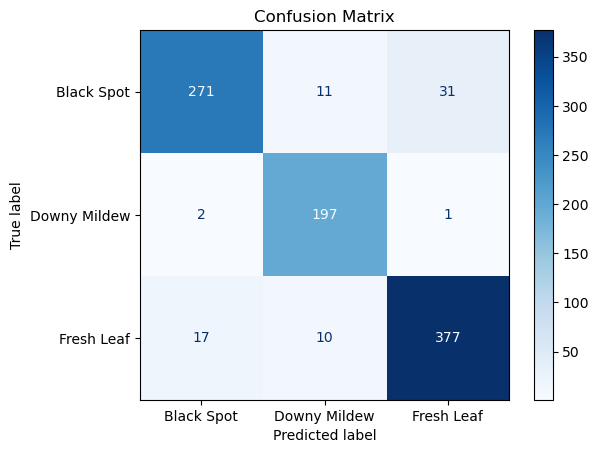

In [13]:
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()